In [ ]:
from langchain.chat_models import ChatOpenAI
import os

llm = ChatOpenAI(
    model="mistralai/Mistral-7B-Instruct-v0.1",
    openai_api_key=os.getenv("TOGETHER_API_KEY"),  
    openai_api_base="https://api.together.xyz/v1",  
    temperature=0.5
)


In [ ]:
#Langchain anf LLM imports

from langchain_groq import ChatGroq

# Document Loading anf Vector store
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings 

# Prompting and Document Utilities
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain

# Core and Output Parsers
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod

# LangGraph for Workflow Graphs
from langgraph.graph import END, StateGraph

# Standard Library Imports
from time import monotonic
from dotenv import load_dotenv
from pprint import pprint
import os

# Datasets and Typing 
from datasets import Dataset
from typing_extensions import TypedDict
from IPython.display import display, Image
from typing import List, TypedDict


In [ ]:
#RAGAS Metrics for Evaluation 
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
)

In [ ]:
import langgraph
from helper_functions import (
    num_tokens_from_string,
    replace_t_with_space,
    replace_double_lines_with_one_line,
    split_into_chapters,
    analyse_metric_results,
    escape_quotes,
    text_wrap,
    extract_book_quotes_as_documents
)



In [ ]:

load_dotenv(override=True)


In [ ]:
# --- Set API Keys for OpenAI and Groq ---
from dotenv import load_dotenv

load_dotenv()
# This line reads the .env file and loads those keys into your Python environment, so you can later access them
os.environ["TOGETHER_API_KEY"] = os.getenv('TOGETHER_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')


In [ ]:
import os

hp_pdf_path = "Harry_Potter_Book_1_The_Sorcerers_Stone.pdf"

if not os.path.isfile(hp_pdf_path):
    raise FileNotFoundError(f" File not found at: {os.path.abspath(hp_pdf_path)}")
else:
    print(f" File found at: {os.path.abspath(hp_pdf_path)}")


In [ ]:

chapters = split_into_chapters(hp_pdf_path)

chapters = replace_t_with_space(chapters)

print(len(chapters))

In [ ]:

loader = PyPDFLoader(hp_pdf_path)
document = loader.load()

document_cleaned = replace_t_with_space(document)

book_quotes_list = extract_book_quotes_as_documents(document_cleaned)

In [ ]:

# Define the template string for summarization.
summarization_prompt_template = """Write an extensive summary of the following:

{text}

SUMMARY:"""

# Create a PromptTemplate object using the template string.
summarization_prompt = PromptTemplate(
    template=summarization_prompt_template,
    input_variables=["text"]
)

In [ ]:
def create_chapter_summary(chapter):

    chapter_txt = chapter.page_content

    # Specify the LLM model and configuration
    model_name = "gpt-3.5-turbo-0125"
    llm = ChatOpenAI(temperature=0, model_name=model_name)
    gpt_35_turbo_max_tokens = 16000  # Maximum token limit for the model
    verbose = False  # Set to True for more detailed output

    # Calculate the number of tokens in the chapter text
    num_tokens = num_tokens_from_string(chapter_txt, model_name)

    # Choose the summarization chain type based on token count
    if num_tokens < gpt_35_turbo_max_tokens:
        # For shorter chapters, use the "stuff" chain type
        chain = load_summarize_chain(
            llm,
            chain_type="stuff",
            prompt=summarization_prompt,
            verbose=verbose
        )
    else:
        # For longer chapters, use the "map_reduce" chain type
        chain = load_summarize_chain(
            llm,
            chain_type="map_reduce",
            map_prompt=summarization_prompt,
            combine_prompt=summarization_prompt,
            verbose=verbose
        )

    # Start timer to measure summarization time
    start_time = monotonic()

    # Create a Document object for the chapter
    doc_chapter = Document(page_content=chapter_txt)

    # Generate the summary using the selected chain
    summary_result = chain.invoke([doc_chapter])

    # Print chain type and execution time for reference
    print(f"Chain type: {chain.__class__.__name__}")
    print(f"Run time: {monotonic() - start_time}")

    # Clean up the summary text (remove double newlines, etc.)
    summary_text = replace_double_lines_with_one_line(summary_result["output_text"])

    # Create a Document object for the summary, preserving chapter metadata
    doc_summary = Document(page_content=summary_text, metadata=chapter.metadata)

    return doc_summary

In [ ]:
import time

chapter_summaries = []
for chapter in chapters:
    for attempt in range(3):  # Try up to 3 times
        try:
            summary = create_chapter_summary(chapter)
            chapter_summaries.append(summary)
            time.sleep(1.5)  # Respecr rate
            break
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            time.sleep(2 ** attempt)  # Backoff
    else:
        print("Giving up on this chapter.")


In [ ]:
def encode_book(path, chunk_size=1000, chunk_overlap=200):

    #  Load the PDF document using PyPDFLoader
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split the document into chunks for embedding
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    texts = text_splitter.split_documents(documents)

    # Clean up the text chunks (replace unwanted characters)
    cleaned_texts = replace_t_with_space(texts)

    # Create OpenAI embeddings and encode the cleaned text chunks into a FAISS vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    # Return the vector store
    return vectorstore

In [ ]:
def encode_chapter_summaries(chapter_summaries):
   
    # Create OpenAI embeddings instance
    embeddings = OpenAIEmbeddings()
    
    # Encode the chapter summaries into a FAISS vector store
    chapter_summaries_vectorstore = FAISS.from_documents(chapter_summaries, embeddings)
    
    # Return the vector store
    return chapter_summaries_vectorstore

In [ ]:
def encode_quotes(book_quotes_list):
    
    # Create OpenAI embeddings instance
    embeddings = OpenAIEmbeddings()
    
    # Encode the book quotes into a FAISS vector store
    quotes_vectorstore = FAISS.from_documents(book_quotes_list, embeddings)
    
    # Return the vector store
    return quotes_vectorstore

In [ ]:
# Check if the vector stores already exist on disk
if (
    os.path.exists("chunks_vector_store") and
    os.path.exists("chapter_summaries_vector_store") and
    os.path.exists("book_quotes_vectorstore")
):
    # If vector stores exist, load them using OpenAI embeddings
    embeddings = OpenAIEmbeddings()
    chunks_vector_store = FAISS.load_local(
        "chunks_vector_store", embeddings, allow_dangerous_deserialization=True
    )
    chapter_summaries_vector_store = FAISS.load_local(
        "chapter_summaries_vector_store", embeddings, allow_dangerous_deserialization=True
    )
    book_quotes_vectorstore = FAISS.load_local(
        "book_quotes_vectorstore", embeddings, allow_dangerous_deserialization=True
    )
else:
    # If vector stores do not exist, encode and save them

    #  Encode the book into a vector store of chunks
    chunks_vector_store = encode_book(hp_pdf_path, chunk_size=1000, chunk_overlap=200)

    # Encode the chapter summaries into a vector store
    chapter_summaries_vector_store = encode_chapter_summaries(chapter_summaries)

    # Encode the book quotes into a vector store
    book_quotes_vectorstore = encode_quotes(book_quotes_list)

    # Save the vector stores to disk for future use
    chunks_vector_store.save_local("chunks_vector_store")
    chapter_summaries_vector_store.save_local("chapter_summaries_vector_store")
    book_quotes_vectorstore.save_local("book_quotes_vectorstore")

In [ ]:

# Retriever for book chunks (returns the top 1 most relevant chunk)
chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 1})

# Retriever for chapter summaries (returns the top 1 most relevant summary)
chapter_summaries_query_retriever = chapter_summaries_vector_store.as_retriever(search_kwargs={"k": 1})

# Retriever for book quotes (returns the top 10 most relevant quotes)
book_quotes_query_retriever = book_quotes_vectorstore.as_retriever(search_kwargs={"k": 10})

In [ ]:

def retrieve_context_per_question(state):
  
    question = state["question"]

    # Retrieve relevant book chunks
    print("Retrieving relevant chunks...")
    docs = chunks_query_retriever.get_relevant_documents(question)
    context = " ".join(doc.page_content for doc in docs)

    # Retrieve relevant chapter summaries
    print("Retrieving relevant chapter summaries...")
    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(question)
    context_summaries = " ".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )

    # Retrieve relevant book quotes
    print("Retrieving relevant book quotes...")
    docs_book_quotes = book_quotes_query_retriever.get_relevant_documents(question)
    book_quotes = " ".join(doc.page_content for doc in docs_book_quotes)

    # Aggregate all contexts and escape problematic characters
    all_contexts = context + context_summaries + book_quotes
    all_contexts = escape_quotes(all_contexts)

    return {"context": all_contexts, "question": question}

In [ ]:


# Prompt template for filtering relevant content from retrieved documents
keep_only_relevant_content_prompt_template = """
You receive a query: {query} and retrieved documents: {retrieved_documents} from a vector store.
You need to filter out all the non relevant information that doesn't supply important information regarding the {query}.
Your goal is just to filter out the non relevant information.
You can remove parts of sentences that are not relevant to the query or remove whole sentences that are not relevant to the query.
DO NOT ADD ANY NEW INFORMATION THAT IS NOT IN THE RETRIEVED DOCUMENTS.
Output the filtered relevant content.
"""

# Output schema for the filtered relevant content
class KeepRelevantContent(BaseModel):
    relevant_content: str = Field(
        description="The relevant content from the retrieved documents that is relevant to the query."
    )

# Create the prompt for the LLM
keep_only_relevant_content_prompt = PromptTemplate(
    template=keep_only_relevant_content_prompt_template,
    input_variables=["query", "retrieved_documents"],
)

# Initialize the LLM for filtering relevant content
keep_only_relevant_content_llm = ChatOpenAI(
    temperature=0, model_name="gpt-4o", max_tokens=2000
)

# Create the LLM chain for filtering relevant content
keep_only_relevant_content_chain = (
    keep_only_relevant_content_prompt
    | keep_only_relevant_content_llm.with_structured_output(KeepRelevantContent)
)

def keep_only_relevant_content(state):
    question = state["question"]
    context = state["context"]

    input_data = {
        "query": question,
        "retrieved_documents": context
    }

    print("Keeping only the relevant content...")
    pprint("--------------------")
    output = keep_only_relevant_content_chain.invoke(input_data)
    relevant_content = output.relevant_content
    relevant_content = "".join(relevant_content)
    relevant_content = escape_quotes(relevant_content)

    return {
        "relevant_context": relevant_content,
        "context": context,
        "question": question
    }

In [ ]:
# Function to Rewrite a Question for Better Vectorstore Retrieval

class RewriteQuestion(BaseModel):
    """
    Output schema for the rewritten question.
    """
    rewritten_question: str = Field(
        description="The improved question optimized for vectorstore retrieval."
    )
    explanation: str = Field(
        description="The explanation of the rewritten question."
    )

# Create a JSON parser for the output schema
rewrite_question_string_parser = JsonOutputParser(pydantic_object=RewriteQuestion)

# Initialize the LLM for rewriting questions
rewrite_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Define the prompt template for question rewriting
rewrite_prompt_template = """
You are a question re-writer that converts an input question to a better version optimized for vectorstore retrieval.
Analyze the input question {question} and try to reason about the underlying semantic intent / meaning.
{format_instructions}
"""

# Create the prompt object
rewrite_prompt = PromptTemplate(
    template=rewrite_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": rewrite_question_string_parser.get_format_instructions()},
)

# Combine prompt, LLM, and parser into a chain
question_rewriter = rewrite_prompt | rewrite_llm | rewrite_question_string_parser

def rewrite_question(state):
    """
    Rewrites the given question using the LLM to optimize it for vectorstore retrieval.

    Args:
        state (dict): A dictionary containing the question to rewrite, with key "question".

    Returns:
        dict: A dictionary with the rewritten question under the key "question".
    """
    question = state["question"]
    print("Rewriting the question...")
    result = question_rewriter.invoke({"question": question})
    new_question = result["rewritten_question"]
    return {"question": new_question}

In [ ]:
# LLM-based Function to Answer a Question from Context Using Chain-of-Thought Reasoning 

# Define the output schema for the answer
class QuestionAnswerFromContext(BaseModel):
    answer_based_on_content: str = Field(
        description="Generates an answer to a query based on a given context."
    )

# Initialize the LLM for answering questions with chain-of-thought reasoning
question_answer_from_context_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Define the prompt template with chain-of-thought examples and instructions
question_answer_cot_prompt_template = """ 
Examples of Chain-of-Thought Reasoning

Example 1

Context: Mary is taller than Jane. Jane is shorter than Tom. Tom is the same height as David.
Question: Who is the tallest person?
Reasoning Chain:
The context tells us Mary is taller than Jane
It also says Jane is shorter than Tom
And Tom is the same height as David
So the order from tallest to shortest is: Mary, Tom/David, Jane
Therefore, Mary must be the tallest person

Example 2
Context: Harry was reading a book about magic spells. One spell allowed the caster to turn a person into an animal for a short time. Another spell could levitate objects.
 A third spell created a bright light at the end of the caster's wand.
Question: Based on the context, if Harry cast these spells, what could he do?
Reasoning Chain:
The context describes three different magic spells
The first spell allows turning a person into an animal temporarily
The second spell can levitate or float objects
The third spell creates a bright light
If Harry cast these spells, he could turn someone into an animal for a while, make objects float, and create a bright light source
So based on the context, if Harry cast these spells he could transform people, levitate things, and illuminate an area
Instructions.

Example 3 
Context: Harry Potter woke up on his birthday to find a present at the end of his bed. He excitedly opened it to reveal a Nimbus 2000 broomstick.
Question: Why did Harry receive a broomstick for his birthday?
Reasoning Chain:
The context states that Harry Potter woke up on his birthday and received a present - a Nimbus 2000 broomstick.
However, the context does not provide any information about why he received that specific present or who gave it to him.
There are no details about Harry's interests, hobbies, or the person who gifted him the broomstick.
Without any additional context about Harry's background or the gift-giver's motivations, there is no way to determine the reason he received a broomstick as a birthday present.

For the question below, provide your answer by first showing your step-by-step reasoning process, breaking down the problem into a chain of thought before arriving at the final answer,
 just like in the previous examples.
Context
{context}
Question
{question}
"""

# Create the prompt object
question_answer_from_context_cot_prompt = PromptTemplate(
    template=question_answer_cot_prompt_template,
    input_variables=["context", "question"],
)

# Combine the prompt and LLM into a chain with structured output
question_answer_from_context_cot_chain = (
    question_answer_from_context_cot_prompt
    | question_answer_from_context_llm.with_structured_output(QuestionAnswerFromContext)
)

def answer_question_from_context(state):
    """
    Answers a question from a given context using chain-of-thought reasoning.

    Args:
        state (dict): A dictionary containing:
            - "question": The query question.
            - "context" or "aggregated_context": The context to answer the question from.

    Returns:
        dict: A dictionary containing:
            - "answer": The answer to the question from the context.
            - "context": The context used.
            - "question": The original question.
    """
    # Use 'aggregated_context' if available, otherwise fall back to 'context'
    question = state["question"]
    context = state["aggregated_context"] if "aggregated_context" in state else state["context"]

    input_data = {
        "question": question,
        "context": context
    }

    print("Answering the question from the retrieved context...")

    # Invoke the LLM chain to get the answer
    output = question_answer_from_context_cot_chain.invoke(input_data)
    answer = output.answer_based_on_content
    print(f'answer before checking hallucination: {answer}')

    return {
        "answer": answer,
        "context": context,
        "question": question
    }

In [ ]:

# Prompt template for checking if the retrieved context is relevant to the query
is_relevant_content_prompt_template = """
You receive a query: {query} and a context: {context} retrieved from a vector store. 
You need to determine if the document is relevant to the query. 
{format_instructions}
"""

# Output schema for the relevance check
class Relevance(BaseModel):
    is_relevant: bool = Field(description="Whether the document is relevant to the query.")
    explanation: str = Field(description="An explanation of why the document is relevant or not.")

# JSON parser for the output schema
is_relevant_json_parser = JsonOutputParser(pydantic_object=Relevance)

# Initialize the LLM for relevance checking
is_relevant_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Create the prompt object for the LLM
is_relevant_content_prompt = PromptTemplate(
    template=is_relevant_content_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": is_relevant_json_parser.get_format_instructions()},
)

# Combine prompt, LLM, and parser into a chain
is_relevant_content_chain = is_relevant_content_prompt | is_relevant_llm | is_relevant_json_parser

def is_relevant_content(state):
    """
    Determines if the retrieved context is relevant to the query.

    Args:
        state (dict): A dictionary containing:
            - "question": The query question.
            - "context": The retrieved context to check for relevance.

    Returns:
        str: "relevant" if the context is relevant, "not relevant" otherwise.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
        "query": question,
        "context": context
    }

    # Invoke the LLM chain to determine if the document is relevant
    output = is_relevant_content_chain.invoke(input_data)
    print("Determining if the document is relevant...")
    if output["is_relevant"]:
        print("The document is relevant.")
        return "relevant"
    else:
        print("The document is not relevant.")
        return "not relevant"

In [ ]:
# checking Answer is Grounded

# Define the output schema for the grounding check
class IsGroundedOnFacts(BaseModel):
    """
    Output schema for checking if the answer is grounded in the provided context.
    """
    grounded_on_facts: bool = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

# Initialize the LLM for fact-checking (using GPT-4o)
is_grounded_on_facts_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Define the prompt template for fact-checking
is_grounded_on_facts_prompt_template = """
You are a fact-checker that determines if the given answer {answer} is grounded in the given context {context}
You don't mind if it doesn't make sense, as long as it is grounded in the context.
Output a JSON containing the answer to the question, and apart from the JSON format don't output any additional text.
"""

# Create the prompt object
is_grounded_on_facts_prompt = PromptTemplate(
    template=is_grounded_on_facts_prompt_template,
    input_variables=["context", "answer"],
)

# Create the LLM chain for fact-checking
is_grounded_on_facts_chain = (
    is_grounded_on_facts_prompt
    | is_grounded_on_facts_llm.with_structured_output(IsGroundedOnFacts)
)

In [ ]:
# Chain to Determine if a Question Can Be Fully Answered from Context

# Define the prompt template for the LLM
can_be_answered_prompt_template = """
You receive a query: {question} and a context: {context}. 
You need to determine if the question can be fully answered based on the context.
{format_instructions}
"""

# Define the output schema for the LLM's response
class QuestionAnswer(BaseModel):
    can_be_answered: bool = Field(
        description="binary result of whether the question can be fully answered or not"
    )
    explanation: str = Field(
        description="An explanation of why the question can be fully answered or not."
    )

# Create a JSON parser for the output schema
can_be_answered_json_parser = JsonOutputParser(pydantic_object=QuestionAnswer)

# Create the prompt object for the LLM
answer_question_prompt = PromptTemplate(
    template=can_be_answered_prompt_template,
    input_variables=["question", "context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)

# Initialize the LLM (Groq Llama3) for this task
can_be_answered_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Compose the chain: prompt -> LLM -> output parser
can_be_answered_chain = answer_question_prompt | can_be_answered_llm | can_be_answered_json_parser

In [ ]:
def grade_generation_v_documents_and_question(state):
   
    # Extract relevant fields from state
    context = state["context"]
    answer = state["answer"]
    question = state["question"]

    # 1. Check if the answer is grounded in the provided context (fact-checking)
    print("Checking if the answer is grounded in the facts...")
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result.grounded_on_facts

    if not grounded_on_facts:
        # If not grounded, label as hallucination
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")

        # 2. Check if the question can be fully answered from the context
        input_data = {
            "question": question,
            "context": context
            }
        print("Determining if the question is fully answered...")
        output = can_be_answered_chain.invoke(input_data)
        can_be_answered = output["can_be_answered"]

        if can_be_answered:
            print("The question can be fully answered.")
            return "useful"
        else:
            print("The question cannot be fully answered.")
            return "not_useful"

In [ ]:

# 1. Define the initial state with the question to answer
init_state = {"question": "who is fluffy?"}

# 2. Retrieve relevant context for the question from the vector stores (chunks, summaries, quotes)
context_state = retrieve_context_per_question(init_state)

# 3. Use an LLM to filter and keep only the content relevant to the question from the retrieved context
relevant_content_state = keep_only_relevant_content(context_state)

# 4. Check if the filtered content is relevant to the question using an LLM-based relevance check
is_relevant_content_state = is_relevant_content(relevant_content_state)

# 5. Use an LLM to answer the question based on the relevant context
answer_state = answer_question_from_context(relevant_content_state)

# 6. Grade the generated answer:
final_answer = grade_generation_v_documents_and_question(answer_state)

# 7. Print the final answer
print(answer_state["answer"])

In [ ]:

# Define the state for the workflow graph
class QualitativeRetievalAnswerGraphState(TypedDict):
    question: str
    context: str
    answer: str

# Create the workflow graph object
qualitative_retrieval_answer_workflow = StateGraph(QualitativeRetievalAnswerGraphState)

# Retrieve context for the question from vector stores
qualitative_retrieval_answer_workflow.add_node(
    "retrieve_context_per_question", retrieve_context_per_question
)

# keep only relevant content from the retrieved context
qualitative_retrieval_answer_workflow.add_node(
    "keep_only_relevant_content", keep_only_relevant_content
)

#  Rewrite the question for better retrieval
qualitative_retrieval_answer_workflow.add_node(
    "rewrite_question", rewrite_question
)

# Answer the question from the relevant context 
qualitative_retrieval_answer_workflow.add_node(
    "answer_question_from_context", answer_question_from_context
)

# -------------------------
# Build the Workflow Edges
# -------------------------

# Set the entry point of the workflow
qualitative_retrieval_answer_workflow.set_entry_point("retrieve_context_per_question")

# Edge: After retrieving context, filter to keep only relevant content
qualitative_retrieval_answer_workflow.add_edge(
    "retrieve_context_per_question", "keep_only_relevant_content"
)

# If relevant, answer the question; if not, rewrite the question
qualitative_retrieval_answer_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_relevant_content,
    {
        "relevant": "answer_question_from_context",
        "not relevant": "rewrite_question"
    },
)

# Edge: After rewriting the question, retrieve context again
qualitative_retrieval_answer_workflow.add_edge(
    "rewrite_question", "retrieve_context_per_question"
)

# If hallucination, try answering again; if not useful, rewrite question; if useful, end
qualitative_retrieval_answer_workflow.add_conditional_edges(
    "answer_question_from_context",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "answer_question_from_context",
        "not_useful": "rewrite_question",
        "useful": END
    },
)

# Compile the workflow graph into an executable app
qualitative_retrieval_answer_retrival_app = qualitative_retrieval_answer_workflow.compile()

# Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_retrieval_answer_retrival_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

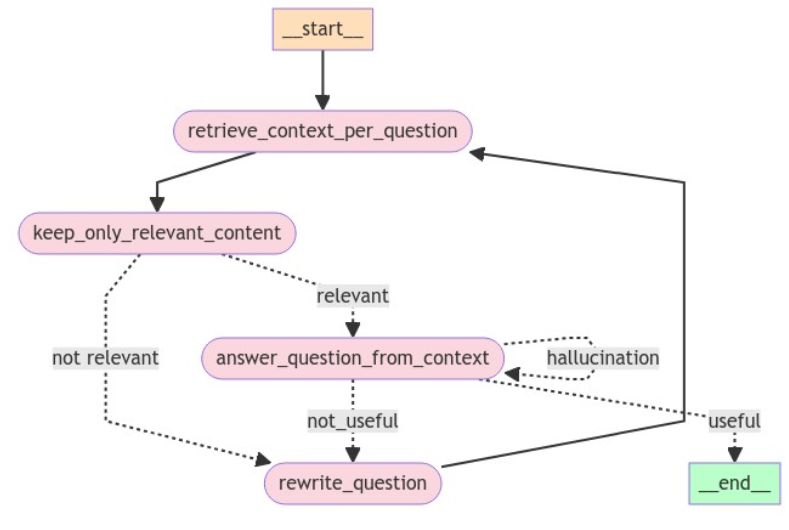

In [ ]:
# --- Function: Check if Distilled Content is Grounded in the Original Context ---

# Prompt template for the LLM to determine grounding
is_distilled_content_grounded_on_content_prompt_template = """
You receive some distilled content: {distilled_content} and the original context: {original_context}.
You need to determine if the distilled content is grounded on the original context.
If the distilled content is grounded on the original context, set the grounded field to true.
If the distilled content is not grounded on the original context, set the grounded field to false.
{format_instructions}
"""

# Output schema for the LLM's response
class IsDistilledContentGroundedOnContent(BaseModel):
    grounded: bool = Field(
        description="Whether the distilled content is grounded on the original context."
    )
    explanation: str = Field(
        description="An explanation of why the distilled content is or is not grounded on the original context."
    )

# JSON parser for the output schema
is_distilled_content_grounded_on_content_json_parser = JsonOutputParser(
    pydantic_object=IsDistilledContentGroundedOnContent
)

# Create the prompt object for the LLM
is_distilled_content_grounded_on_content_prompt = PromptTemplate(
    template=is_distilled_content_grounded_on_content_prompt_template,
    input_variables=["distilled_content", "original_context"],
    partial_variables={
        "format_instructions": is_distilled_content_grounded_on_content_json_parser.get_format_instructions()
    },
)

# Initialize the LLM for this task
is_distilled_content_grounded_on_content_llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192",
    groq_api_key=groq_api_key,
    max_tokens=4000
)

# Compose the chain: prompt -> LLM -> output parser
is_distilled_content_grounded_on_content_chain = (
    is_distilled_content_grounded_on_content_prompt
    | is_distilled_content_grounded_on_content_llm
    | is_distilled_content_grounded_on_content_json_parser
)

def is_distilled_content_grounded_on_content(state):
    
    pprint("--------------------")
    print("Determining if the distilled content is grounded on the original context...")

    distilled_content = state["relevant_context"]
    original_context = state["context"]

    input_data = {
        "distilled_content": distilled_content,
        "original_context": original_context
    }

    # Invoke the LLM chain to check grounding
    output = is_distilled_content_grounded_on_content_chain.invoke(input_data)
    grounded = output["grounded"]

    if grounded:
        print("The distilled content is grounded on the original context.")
        return "grounded on the original context"
    else:
        print("The distilled content is not grounded on the original context.")
        return "not grounded on the original context"

In [ ]:


def retrieve_chunks_context_per_question(state):
    
    print("Retrieving relevant chunks...")
    question = state["question"]
    # Retrieve relevant book chunks using the retriever
    docs = chunks_query_retriever.get_relevant_documents(question)
    # Concatenate the content of the retrieved documents
    context = " ".join(doc.page_content for doc in docs)
    context = escape_quotes(context)
    return {"context": context, "question": question}

def retrieve_summaries_context_per_question(state):
    
    print("Retrieving relevant chapter summaries...")
    question = state["question"]
    # Retrieve relevant chapter summaries using the retriever
    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(question)
    # Concatenate the content of the retrieved summaries, including chapter citation
    context_summaries = " ".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )
    context_summaries = escape_quotes(context_summaries)
    return {"context": context_summaries, "question": question}

def retrieve_book_quotes_context_per_question(state):
    
    question = state["question"]
    print("Retrieving relevant book quotes...")
    # Retrieve relevant book quotes using the retriever
    docs_book_quotes = book_quotes_query_retriever.get_relevant_documents(question)
    # Concatenate the content of the retrieved quotes
    book_quotes = " ".join(doc.page_content for doc in docs_book_quotes)
    book_quotes_context = escape_quotes(book_quotes)
    return {"context": book_quotes_context, "question": question}

In [ ]:

class QualitativeRetrievalGraphState(TypedDict):
    question: str
    context: str
    relevant_context: str

In [ ]:

# 1. Create the workflow graph object with the appropriate state type
qualitative_chunks_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# 2. Define and add nodes to the graph

qualitative_chunks_retrieval_workflow.add_node(
    "retrieve_chunks_context_per_question",
    retrieve_chunks_context_per_question
)
# we keep only the relevant content from the retrieved context
qualitative_chunks_retrieval_workflow.add_node(
    "keep_only_relevant_content",
    keep_only_relevant_content
)

# 3. Set the entry point of the workflow
qualitative_chunks_retrieval_workflow.set_entry_point("retrieve_chunks_context_per_question")

# 4. Add edges to define the workflow
qualitative_chunks_retrieval_workflow.add_edge(
    "retrieve_chunks_context_per_question",
    "keep_only_relevant_content"
)

# Conditional edge: After filtering, check if distilled content is grounded in the original context

qualitative_chunks_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {
        "grounded on the original context": END,
        "not grounded on the original context": "keep_only_relevant_content"
    },
)

# 5. Compile the workflow graph into an executable app
qualitative_chunks_retrieval_workflow_app = qualitative_chunks_retrieval_workflow.compile()

# 6. Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_chunks_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


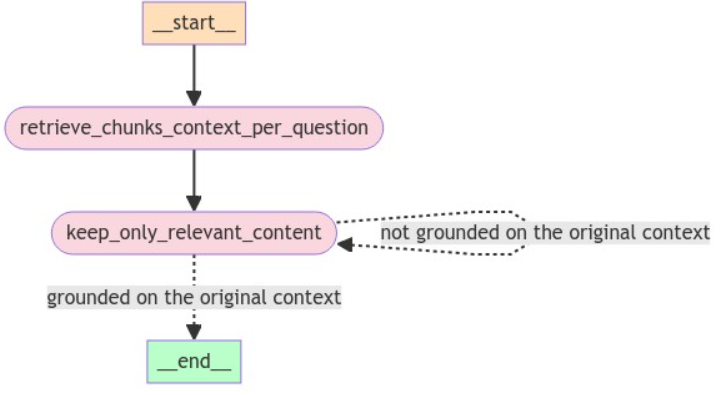

In [ ]:
# workflow graph object with the appropriate state type
qualitative_summaries_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# add nodes to the graph
#  Retrieve relevant context from chapter summaries for the question
qualitative_summaries_retrieval_workflow.add_node(
    "retrieve_summaries_context_per_question",
    retrieve_summaries_context_per_question
)
#keep only the relevant content from the retrieved context
qualitative_summaries_retrieval_workflow.add_node(
    "keep_only_relevant_content",
    keep_only_relevant_content
)

# entry point of the workflow
qualitative_summaries_retrieval_workflow.set_entry_point("retrieve_summaries_context_per_question")

# Add edges to define the workflow
qualitative_summaries_retrieval_workflow.add_edge(
    "retrieve_summaries_context_per_question",
    "keep_only_relevant_content"
)

# If grounded, end; if not, repeat filtering
qualitative_summaries_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {
        "grounded on the original context": END,
        "not grounded on the original context": "keep_only_relevant_content"
    },
)

#Compile the workflow graph into an executable app
qualitative_summaries_retrieval_workflow_app = qualitative_summaries_retrieval_workflow.compile()

# Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_summaries_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

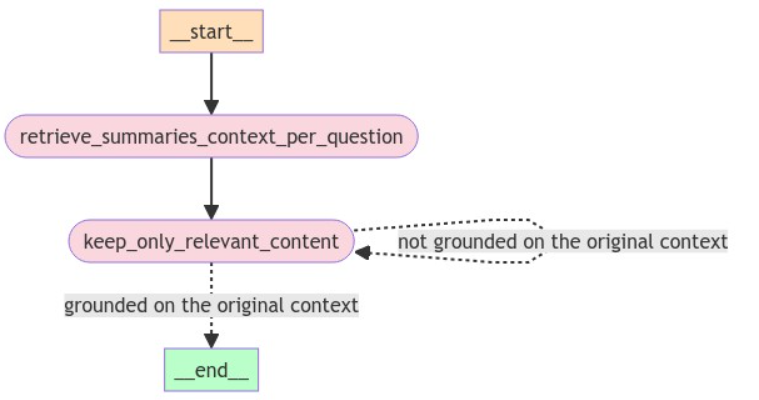

In [ ]:

# Create the workflow graph object with the appropriate state type
qualitative_book_quotes_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)


qualitative_book_quotes_retrieval_workflow.add_node(
    "retrieve_book_quotes_context_per_question",
    retrieve_book_quotes_context_per_question
)
# keep only the relevant content from the retrieved context
qualitative_book_quotes_retrieval_workflow.add_node(
    "keep_only_relevant_content",
    keep_only_relevant_content
)

# entry point of the workflow
qualitative_book_quotes_retrieval_workflow.set_entry_point("retrieve_book_quotes_context_per_question")

# edges to define the workflow
qualitative_book_quotes_retrieval_workflow.add_edge(
    "retrieve_book_quotes_context_per_question",
    "keep_only_relevant_content"
)
# If grounded, end; if not, repeat filtering
qualitative_book_quotes_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {
        "grounded on the original context": END,
        "not grounded on the original context": "keep_only_relevant_content"
    },
)

# workflow graph into an executable app
qualitative_book_quotes_retrieval_workflow_app = qualitative_book_quotes_retrieval_workflow.compile()

# Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_book_quotes_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

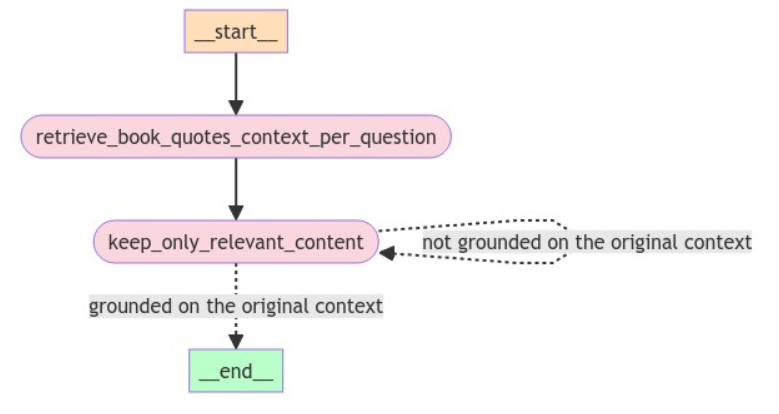

In [ ]:

init_state = {
    "question": "worse than getting killed"  # The question to answer
}

In [ ]:

for output in qualitative_chunks_retrieval_workflow_app.stream(init_state):
    for _, value in output.items():
        pass  # The value variable will hold the latest state after each node execution
    pprint("--------------------")  # Print a separator for clarity between steps

# After the workflow completes, print the final relevant context extracted
print(f'relevant context: {value["relevant_context"]}')

In [ ]:

for output in qualitative_summaries_retrieval_workflow_app.stream(init_state):
    # Iterate through the output items (node name, value)
    for _, value in output.items():
        pass
    pprint("--------------------")  # Print a separator for clarity between steps

print(f'relevant context: {value["relevant_context"]}')

In [ ]:

for output in qualitative_book_quotes_retrieval_workflow_app.stream(init_state):
    for _, value in output.items():
        pass  
    pprint("--------------------")  # Print a separator for clarity between steps

print(f'relevant context: {value["relevant_context"]}')

In [ ]:
def is_answer_grounded_on_context(state):
    print("Checking if the answer is grounded in the facts...")

    # Extract context and answer from the state
    context = state["context"]
    answer = state["answer"]

    # Use the LLM chain to check if the answer is grounded in the context
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result.grounded_on_facts

    # Return the result based on grounding
    if not grounded_on_facts:
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")
        return "grounded on context"

In [ ]:
class QualitativeAnswerGraphState(TypedDict):
    
    question: str
    context: str
    answer: str

# Create the workflow graph object
qualitative_answer_workflow = StateGraph(QualitativeAnswerGraphState)

qualitative_answer_workflow.add_node(
    "answer_question_from_context",
    answer_question_from_context
)

qualitative_answer_workflow.set_entry_point("answer_question_from_context")
qualitative_answer_workflow.add_conditional_edges(
    "answer_question_from_context",
    is_answer_grounded_on_context,
    {
        "hallucination": "answer_question_from_context",
        "grounded on context": END
    }
)

# Compile the workflow graph into an executable app
qualitative_answer_workflow_app = qualitative_answer_workflow.compile()

# Display the workflow graph as a Mermaid diagram
display(
    Image(
        qualitative_answer_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


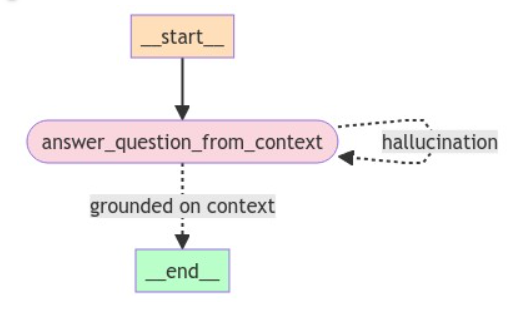

In [ ]:

question = "who is harry?"  # The question to answer
context = "Harry Potter is a cat."  # The context to answer the question from

init_state = {
    "question": question,
    "context": context
}

for output in qualitative_answer_workflow_app.stream(init_state):
    for _, value in output.items():
        pass  # The value variable holds the latest state after each node execution
    pprint("--------------------")  # Print a separator for clarity between steps

# After the workflow completes, print the final answer generated by the workflow
print(f'answer: {value["answer"]}')

In [ ]:
from typing import TypedDict, List, Dict

class PlanExecute(TypedDict):
    curr_state: str
    question: str
    anonymized_question: str
    query_to_retrieve_or_answer: str
    plan: List[str]
    past_steps: List[str]
    mapping: Dict[str, str]
    curr_context: str
    aggregated_context: str
    tool: str
    response: str

In [ ]:
from typing import List
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Plan(BaseModel):
    """
    Represents a step-by-step plan to answer a given question.
    Attributes:
        steps (List[str]): Ordered list of steps to follow.
    """
    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

# Prompt template for generating a plan from a question
planner_prompt = """
For the given query {question}, come up with a simple step by step plan of how to figure out the answer. 

This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
"""

planner_prompt = PromptTemplate(
    template=planner_prompt,
    input_variables=["question"],
)

# Initialize the LLM for planning (using GPT-4o)
planner_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the planning chain: prompt -> LLM -> structured output
planner = planner_prompt | planner_llm.with_structured_output(Plan)

In [ ]:

break_down_plan_prompt_template = """
You receive a plan {plan} which contains a series of steps to follow in order to answer a query. 
You need to go through the plan and refine it according to these rules:
1. Every step must be executable by one of the following:
    i. Retrieving relevant information from a vector store of book chunks
    ii. Retrieving relevant information from a vector store of chapter summaries
    iii. Retrieving relevant information from a vector store of book quotes
    iv. Answering a question from a given context.
2. Every step should contain all the information needed to execute it.

Output the refined plan.
"""

# Create a PromptTemplate for the LLM
break_down_plan_prompt = PromptTemplate(
    template=break_down_plan_prompt_template,
    input_variables=["plan"],
)

# Initialize the LLM for plan breakdown (using GPT-4o)
break_down_plan_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o",
    max_tokens=2000
)

# Compose the chain: prompt -> LLM -> structured output (Plan)
break_down_plan_chain = break_down_plan_prompt | break_down_plan_llm.with_structured_output(Plan)